# Computing the Maximum Lyapunov Exponent via displacement

We compare the MLE for standard training and robust training

In [28]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
import matplotlib.pyplot as plt
import numpy as np

# Juptyer magic: For export. Makes the plots size right for the screen 
%matplotlib inline
# %config InlineBackend.figure_format = 'retina'

%config InlineBackend.figure_formats = ['svg'] 


torch.backends.cudnn.deterministic = True
seed = np.random.randint(1,200)
seed = 59
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
print(seed)
g = torch.Generator()
g.manual_seed(seed)

59



# Data preparation

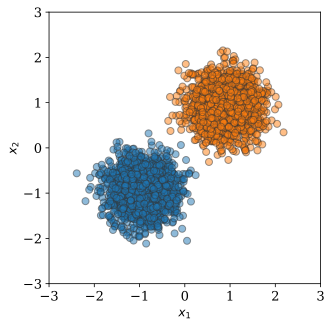

In [29]:
cross_entropy = False #this leads to squared loss in the training
data_noise = 0.4
batch_size = 5000
plotlim = [-3, 3]
subfolder = 'traj_moons'


if cross_entropy == True:
    label = 'scalar'
else: label = 'vector'


from models.training import create_dataloader
dataloader, dataloader_viz = create_dataloader('blobs', noise = data_noise, batch_size = batch_size, plotlim = plotlim, random_state = seed, label = label)


## Model dynamics

In [30]:
#Import of the model dynamics that describe the neural ODE
#The dynamics are based on the torchdiffeq package, that implements ODE solvers in the pytorch setting
from models.neural_odes import NeuralODE, NeuralODEvar

#for neural ODE based networks the network width is constant. In this example the input is 2 dimensional
hidden_dim, data_dim = 2, 2 
augment_dim = 0

#T is the end time of the neural ODE evolution, num_steps are the amount of discretization steps for the ODE solver
T, num_steps = 10, 50 #!!!
param_layers = 1
bound = 0.
fp = False #this recent change made things not work anymore
turnpike = False

non_linearity = 'tanh' #'relu' #
architecture = 'outside' #outside

dt = T/num_steps

print(dt)


0.2


## Training and generating level sets

In [31]:

num_epochs = 30 #number of optimization runs in which the dataset is used for gradient decent

torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
anode = NeuralODEvar(device, data_dim, hidden_dim, augment_dim=augment_dim, non_linearity=non_linearity, 
                    architecture=architecture, T=T, time_steps=num_steps, num_params = param_layers, fixed_projector=fp, cross_entropy=cross_entropy)

# anode = NeuralODE(device, data_dim, hidden_dim, augment_dim=augment_dim, non_linearity=non_linearity, 
#                     architecture=architecture, T=T, time_steps=num_steps, fixed_projector=fp, cross_entropy=cross_entropy)

optimizer_anode = torch.optim.Adam(anode.parameters(), lr=1e-3) 

In [32]:
from models.training import doublebackTrainer

trainer_anode = doublebackTrainer(anode, optimizer_anode, device, cross_entropy=cross_entropy, turnpike = turnpike,
                         bound=bound, fixed_projector=fp, verbose = True, eps_comp = 0.2) 
trainer_anode.train(dataloader, num_epochs)


Iteration 0/63
Loss: 5.921

Iteration 10/63
Loss: 7.471

Iteration 20/63
Loss: 6.382

Iteration 30/63
Loss: 3.408

Iteration 40/63
Loss: 4.023

Iteration 50/63
Loss: 3.726

Iteration 60/63
Loss: 3.096
Epoch 1: 4.807

Iteration 0/63
Loss: 3.167

Iteration 10/63
Loss: 2.840

Iteration 20/63
Loss: 2.346

Iteration 30/63
Loss: 2.316

Iteration 40/63
Loss: 2.853

Iteration 50/63
Loss: 2.099

Iteration 60/63
Loss: 2.153
Epoch 2: 2.451

Iteration 0/63
Loss: 2.062

Iteration 10/63
Loss: 1.932

Iteration 20/63
Loss: 2.023

Iteration 30/63
Loss: 1.577

Iteration 40/63
Loss: 1.817

Iteration 50/63
Loss: 1.900

Iteration 60/63
Loss: 1.479
Epoch 3: 1.858

Iteration 0/63
Loss: 1.743

Iteration 10/63
Loss: 1.557

Iteration 20/63
Loss: 1.712

Iteration 30/63
Loss: 1.482

Iteration 40/63
Loss: 1.507

Iteration 50/63
Loss: 1.446

Iteration 60/63
Loss: 1.257
Epoch 4: 1.531

Iteration 0/63
Loss: 1.389

Iteration 10/63
Loss: 1.356

Iteration 20/63
Loss: 1.277

Iteration 30/63
Loss: 1.244

Iteration 40/63


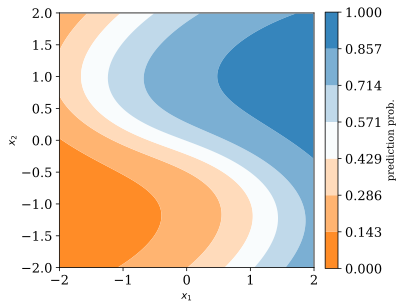

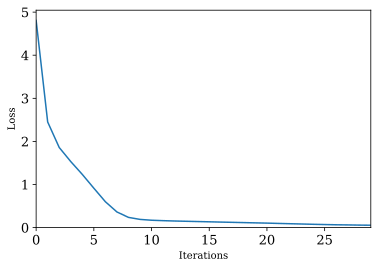

In [33]:
from plots.plots import classification_levelsets
classification_levelsets(anode)
plt.plot(trainer_anode.histories['epoch_loss_history'])
plt.xlim(0, len(trainer_anode.histories['epoch_loss_history']) - 1)
plt.ylim(0)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.show()

In [34]:

#check that right hand side is autonomous
input1 = torch.tensor([1, 0], dtype=torch.float32)
times = torch.linspace(0,T,30)
times = times[:-1]
for t in times:
   k = int(t/dt)
   print('output', anode.flow.dynamics(t,input1),t)
   print(k)
   print('dynamics weight:', anode.flow.dynamics.fc2_time[k].weight)
   print('right hand-side', anode.flow.dynamics.forward(t, input1))

output tensor([ 0.3236, -0.2159], grad_fn=<TanhBackward>) tensor(0.)
0
dynamics weight: Parameter containing:
tensor([[ 0.2077,  0.7977],
        [-0.1745, -0.0281]], requires_grad=True)
right hand-side tensor([ 0.3236, -0.2159], grad_fn=<TanhBackward>)
output tensor([ 0.3236, -0.2159], grad_fn=<TanhBackward>) tensor(0.3448)
1


IndexError: index 1 is out of range

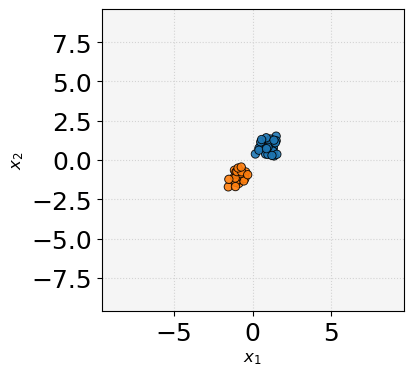

In [ ]:
from plots.gifs import trajectory_gif
from IPython.display import Image

#the function trajectory_gif creates the evolution trajectories of the input data through the network
#the passing time corresponds to the depth of the network

for X_viz, y_viz in dataloader_viz:
    trajectory_gif(anode, X_viz[0:50], y_viz[0:50], timesteps=num_steps, filename = 'trajectory.gif', axlim = 8, dpi = 100)
    break

#Display of the generated gif
traj = Image(filename="trajectory.gif")
display(traj)

amount steps 7


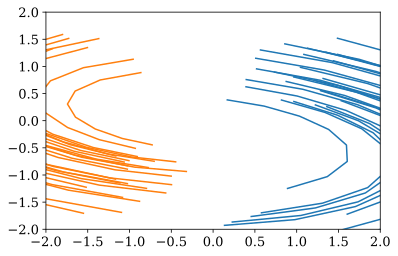

amount steps 6


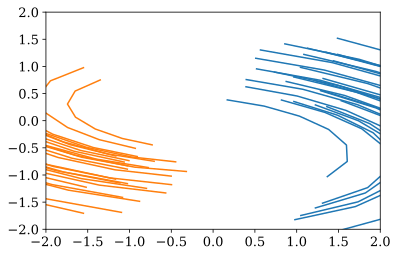

amount steps 5


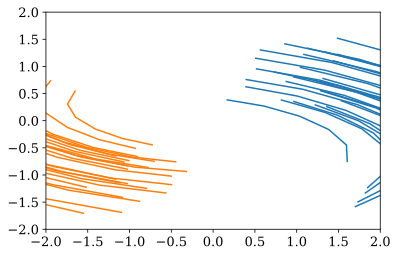

amount steps 4


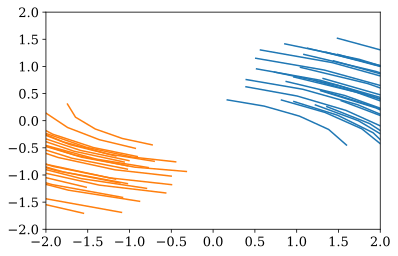

amount steps 3


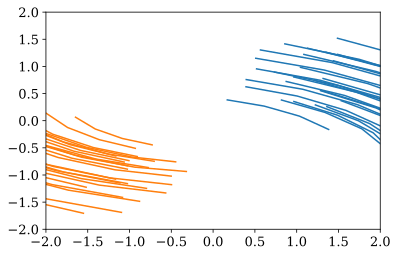

In [114]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

def plot_trajectory(model, inputs, targets, stepsize, time_interval = None, dpi=200, alpha=0.9,
                    alpha_line=1, axlim=0, ticks=True):
    from matplotlib import rc
    rc("text", usetex=False)
    font = {'size': 18}
    rc('font', **font)

    # Define color based on targets
    color = ['C1' if targets[i,1] > 0.0 else 'C0' for i in range(len(targets))]
    
    
    if time_interval is None:
        time_interval = torch.tensor([0, model.T],dtype=torch.float32)
        
    start_time = time_interval[0].item()
    end_time = time_interval[1].item()
    num_steps_interval = int((end_time - start_time) / stepsize)
    print('amount steps', num_steps_interval)
    integration_time = torch.arange(start_time, end_time + stepsize, stepsize)
    trajectories = model.flow(inputs, integration_time).detach() #output is of dimension [time_steps, number of inputs, dimension per input]

    
    for i in range(inputs.shape[0]):
        plt.plot(trajectories[:,i, 0], trajectories[:,i, 1], linestyle='-', marker='', color = color[i])
        
    
    x_min, x_max = -2,2
    y_min, y_max = -2,2
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    
    
    

    # plt.show()

# Example usage
# model, inputs, targets, timesteps should be defined before calling this function
for begin_T in range(3,8):
    interval = torch.tensor([begin_T, 10], dtype=torch.float32)
    plot_trajectory(anode, X_viz[0:50], y_viz[0:50],stepsize = dt, time_interval=interval)
    plt.show()
    


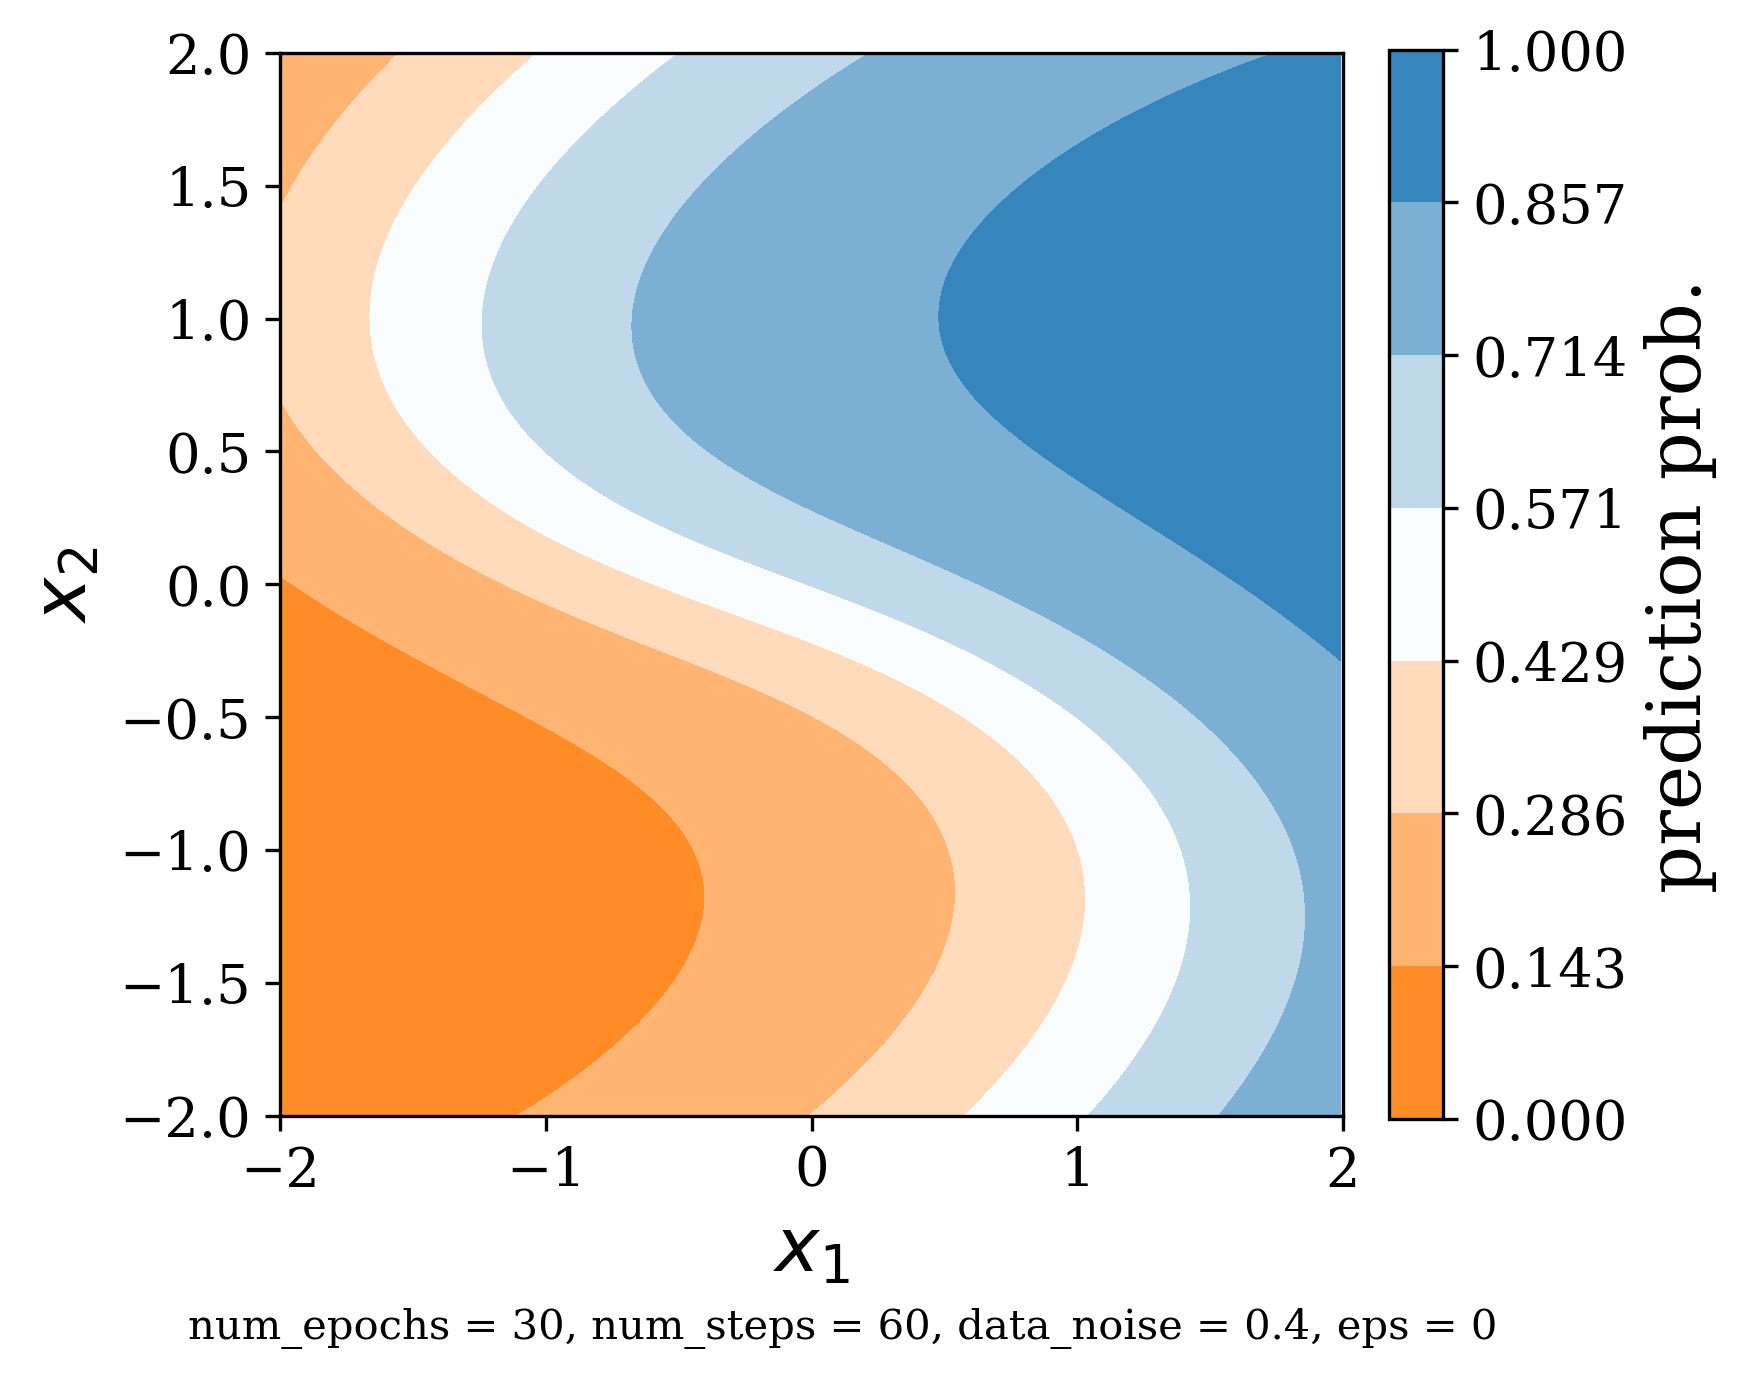

In [9]:
from plots.plots import classification_levelsets
import os

if not os.path.exists(subfolder):
        os.makedirs(subfolder)
        
footnote = f'{num_epochs = }, {num_steps = }, {data_noise = }'
        
fig_name_base = os.path.join(subfolder, 'levelsets')
classification_levelsets(anode, fig_name_base, footnote = footnote + ', eps = 0')
from IPython.display import Image
img1 = Image(filename = fig_name_base + '.png', width = 400)

display(img1)

## Lyapunov exponent computation

In [10]:
# Define inputs
input1 = torch.tensor([1, 0], dtype=torch.float32)
input2 = torch.tensor([0, 1], dtype=torch.float32)
time_interval = torch.tensor([0, T], dtype=torch.float32)


def input_to_output(input, node, time_interval = torch.tensor([0, T], dtype=torch.float32)):
    return node.flow(input, time_interval)[-1]

def LEs(input, node, time_interval = torch.tensor([0, T], dtype=torch.float32)):
    #fix the node so it is just a input to output of the other variable
    input_to_output_lambda = lambda input: input_to_output(input, node, time_interval)
    # Compute the Jacobian matrix
    J = torch.autograd.functional.jacobian(input_to_output_lambda, input)
    
    # Perform Singular Value Decomposition
    U, S, V = torch.svd(J)
    
    # Return the maximum singular value
    return 1/(time_interval[1]-time_interval[0]) * np.log(S)

# def LEs(singular_values,T):
#     return 1/T * np.log(singular_values)
    

def input_to_output_elena(input):
    return anode.flow.dynamics.forward(T-1,input)


les = LEs(input1, anode)
print(les)


tensor([0.1178, 0.0162])


# Plot ANODE

In [11]:
def LE_grid(node, x_amount = 100, time_interval = torch.tensor([0, T], dtype=torch.float32)):
        
        x = torch.linspace(-2,2,x_amount)
        y = torch.linspace(-2,2,x_amount)
        X, Y = torch.meshgrid(x, y)

        inputs = torch.stack([X,Y], dim=-1)
        inputs = inputs.view(-1,2) #to be able to loop through all the grid values
        inputs_MLE_max = torch.zeros(x_amount * x_amount)
        inputs_MLE_min = torch.zeros(x_amount * x_amount)



        for i, input in enumerate(inputs):
                
                inputs_MLE_max[i] = torch.max(LEs(input, node, time_interval))
                inputs_MLE_min[i] = torch.min(LEs(input, node, time_interval))
        
        
        output_max = inputs_MLE_max.view(x_amount,x_amount)
        output_min = inputs_MLE_min.view(x_amount,x_amount)
        
        return output_max, output_min

output_max, output_min = LE_grid(anode,x_amount = 40)

amount steps 50


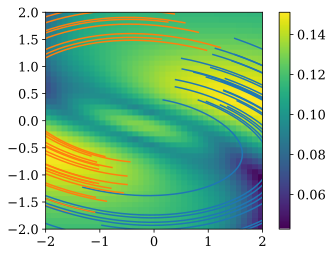

In [106]:
ax_lim = 2

interval = torch.tensor([0., T], dtype=torch.float32)
plot_trajectory(anode, X_viz[0:40], y_viz[0:40],stepsize = dt, time_interval=interval)
anodeimg_max = plt.imshow(np.rot90(output_max), origin='upper', extent=(-ax_lim, ax_lim, -ax_lim, ax_lim),cmap = 'viridis')
vmin_max, vmax_max = anodeimg_max.get_clim()

plt.colorbar()  # Show color scale

plt.show()

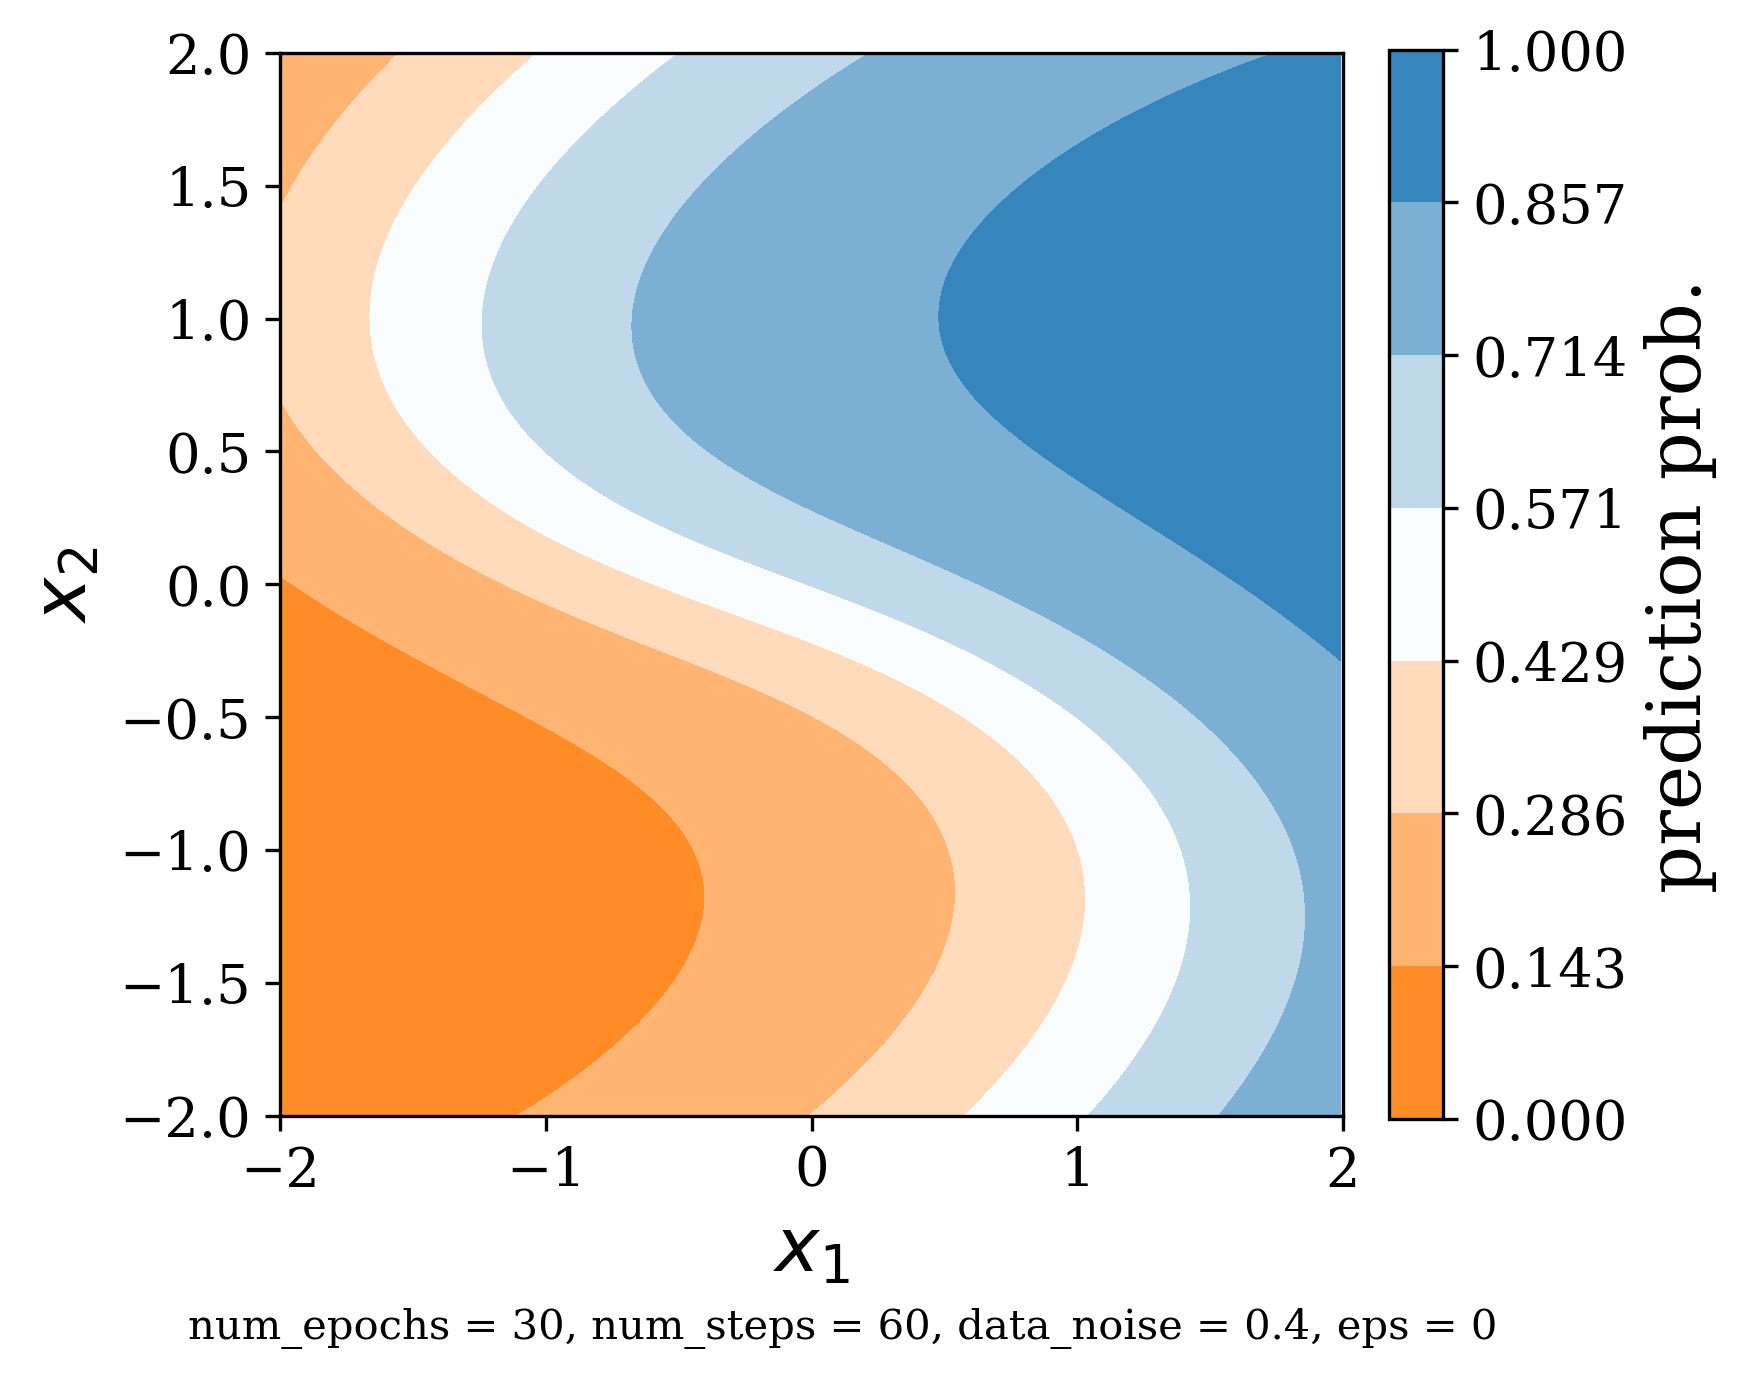

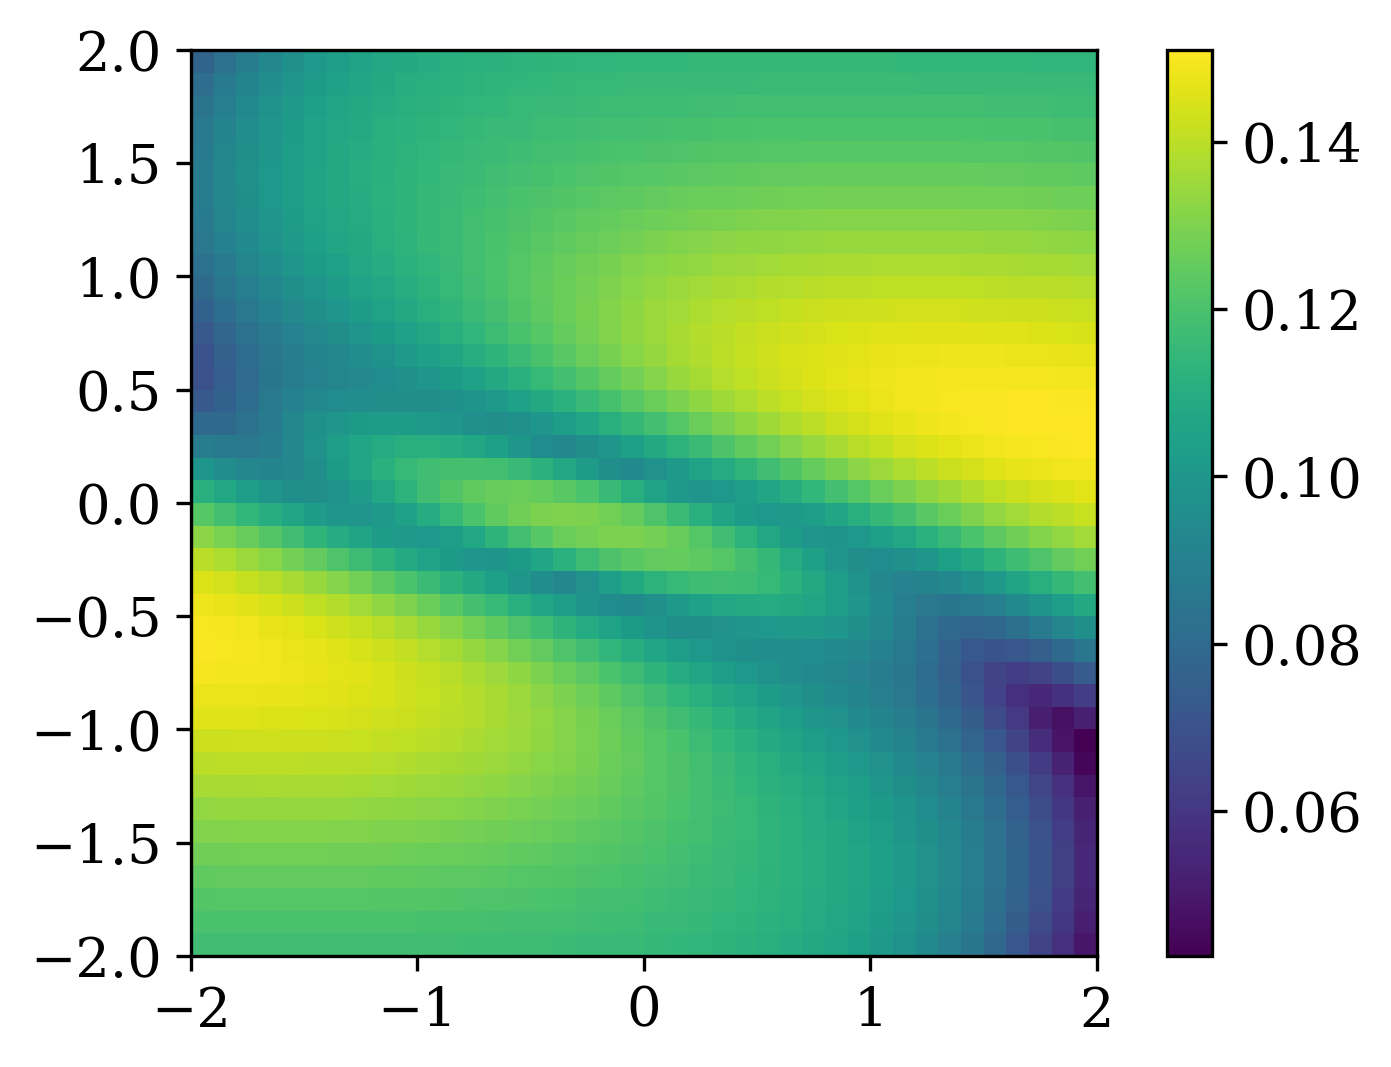

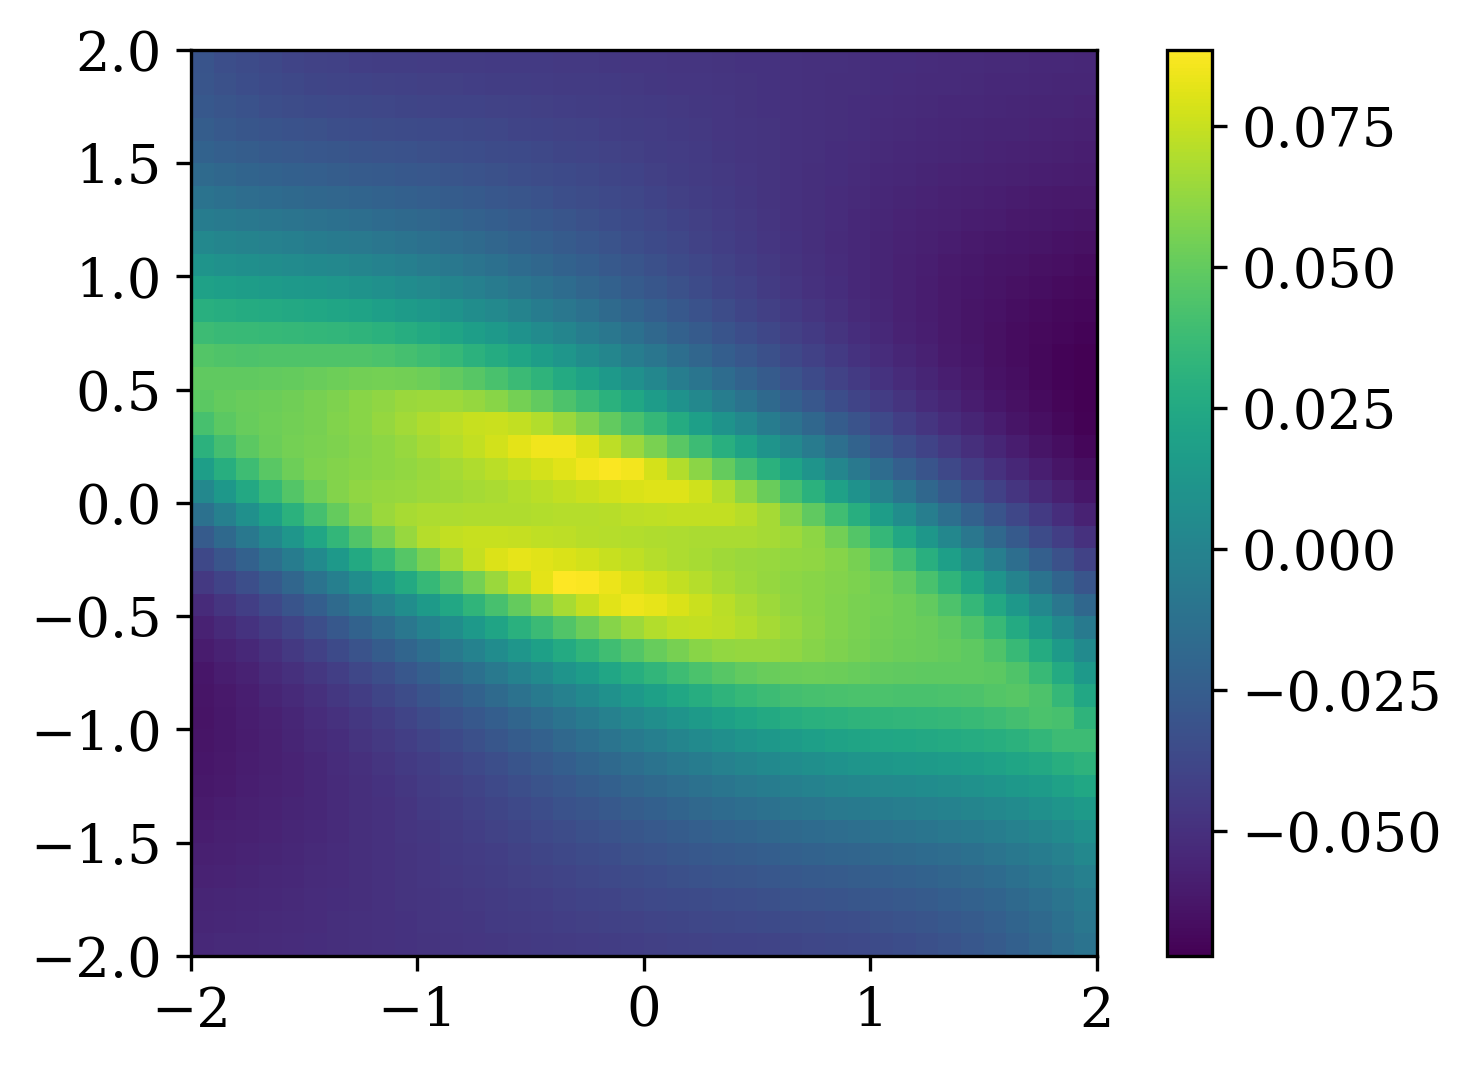

In [12]:


from matplotlib.colors import CenteredNorm, to_rgba, LinearSegmentedColormap

anodeimg_max = plt.imshow(np.rot90(output_max), origin='upper', extent=(-2, 2, -2, 2),cmap = 'viridis')
vmin_max, vmax_max = anodeimg_max.get_clim()

plt.colorbar()  # Show color scale
plt.savefig('MLE_max.png',bbox_inches='tight', dpi=300, format='png', facecolor = 'white')
plt.close()

anodeimg_min = plt.imshow(np.rot90(output_min), origin='upper', extent=(-2, 2, -2, 2),cmap = 'viridis')#, norm=CenteredNorm(vcenter=0)) # cmap='viridis')
vmin_min, vmax_min = anodeimg_min.get_clim()

plt.colorbar()  # Show color scale
plt.savefig('MLE_min.png',bbox_inches='tight', dpi=300, format='png', facecolor = 'white')
plt.close()

img1 = Image(filename = fig_name_base + '.png', width = 400)
img2 = Image(filename = 'MLE_max.png', width = 400)
img3 = Image(filename = 'MLE_min.png', width = 400)

display(img1,img2,img3)

Evolution of the Finite Time Lyapunov Exponents over the whole interval

amount steps 1
amount steps 1
amount steps 1
amount steps 1
amount steps 1
amount steps 1


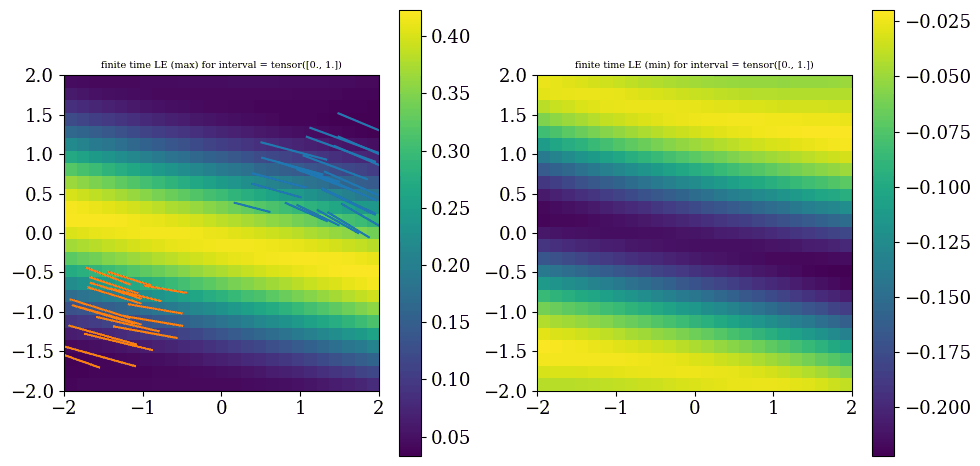

In [117]:
import imageio
import os

# Directory to save images
image_dir = 'gif_images'
if not os.path.exists(image_dir):
    os.makedirs(image_dir)

T = 4
param_layers = 10
dt = 1
x_amount = 25
# Generate and save plots

interval_length = 1
t_values = np.arange(0, T-interval_length, 0.5)
for t in t_values:
    time_interval = torch.tensor([0, interval_length], dtype=torch.float32) + t
    
    output_max, output_min = LE_grid(anode, x_amount, time_interval)
    
    # Create a figure with 2 subplots side by side
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    
    # Plot output_min on the first subplot
    im1 = axs[0].imshow(np.rot90(output_max), origin='upper', extent=(-2, 2, -2, 2), cmap='viridis')
    # im1.set_clim(vmin=vmin_max, vmax=vmax_max)
    fig.colorbar(im1, ax=axs[0], orientation='vertical')  # Show color scale
    axs[0].set_title(f'finite time LE (max) for interval = {time_interval}', fontsize=7)
    plt.sca(axs[0])
    plot_trajectory(anode, X_viz[0:40], y_viz[0:40],stepsize = dt, time_interval=time_interval)
    
    # Plot output_max on the second subplot
    im2 = axs[1].imshow(np.rot90(output_min), origin='upper', extent=(-2, 2, -2, 2), cmap='viridis')
    fig.colorbar(im2, ax=axs[1], orientation='vertical')  # Show color scale
    axs[1].set_title(f'finite time LE (min) for interval = {time_interval}', fontsize=7)
    # im2.set_clim(vmin_min,vmax_min)
    
    
    # Adjust layout to prevent overlap
    plt.tight_layout()
    
    filename = os.path.join(image_dir, f'plot_{t:.1f}.png')
    plt.savefig(filename, bbox_inches='tight', dpi=100, format='png', facecolor='white')
    plt.close()

# Create GIF
images = []
for t in t_values:
    filename = os.path.join(image_dir, f'plot_{t:.1f}.png')
    images.append(imageio.imread(filename))

imageio.mimsave('finite_time_LE_test.gif', images, fps=1)

# Clean up (optional)
for t in t_values:
    os.remove(os.path.join(image_dir, f'plot_{t:.1f}.png'))
os.rmdir(image_dir)

LEevo_test = Image(filename="finite_time_LE_test.gif")
display(LEevo_test)

in the autonomous case any interval of same length should give the same LE. So the above gif makes sense!

tensor([ 0., 10.])
amount steps 10
tensor([ 1., 10.])
amount steps 9
tensor([ 2., 10.])
amount steps 8
tensor([ 3., 10.])
amount steps 7
tensor([ 4., 10.])
amount steps 6
tensor([ 5., 10.])
amount steps 5
tensor([ 6., 10.])
amount steps 4
tensor([ 7., 10.])
amount steps 3
tensor([ 8., 10.])
amount steps 2


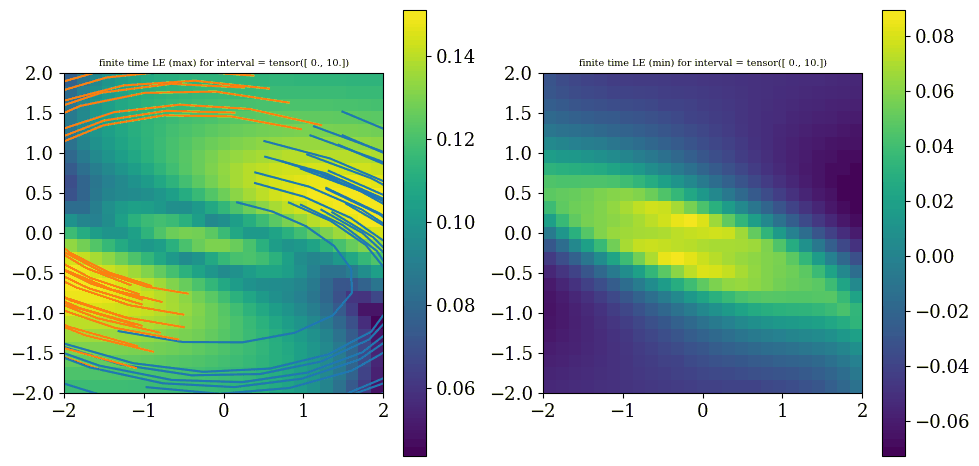

In [120]:
import imageio
import os

# Directory to save images
image_dir = 'gif_images'
if not os.path.exists(image_dir):
    os.makedirs(image_dir)

T = 10
param_layers = 10
dt = 1
x_amount = 25
# Generate and save plots
time_step = 1 #0.3 gave an error probably because i did not adjust dt
dt = T / time_step
t_values = np.arange(0, T-time_step, time_step)
for t in t_values:
    time_interval = torch.tensor([t, T], dtype=torch.float32)
    print(time_interval)
    output_max, output_min = LE_grid(anode, x_amount, time_interval)
    
    # Create a figure with 2 subplots side by side
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    
    # Plot output_min on the first subplot
    im1 = axs[0].imshow(np.rot90(output_max), origin='upper', extent=(-2, 2, -2, 2), cmap='viridis')
    # im1.set_clim(vmin=vmin_max, vmax=vmax_max)
    fig.colorbar(im1, ax=axs[0], orientation='vertical')  # Show color scale
    axs[0].set_title(f'finite time LE (max) for interval = {time_interval}', fontsize=7)
    plt.sca(axs[0])
    plot_trajectory(anode, X_viz[0:40], y_viz[0:40],stepsize = dt, time_interval=time_interval)
    
    # Plot output_max on the second subplot
    im2 = axs[1].imshow(np.rot90(output_min), origin='upper', extent=(-2, 2, -2, 2), cmap='viridis')
    fig.colorbar(im2, ax=axs[1], orientation='vertical')  # Show color scale
    axs[1].set_title(f'finite time LE (min) for interval = {time_interval}', fontsize=7)
    # im2.set_clim(vmin_min,vmax_min)
    
    
    # Adjust layout to prevent overlap
    plt.tight_layout()
    
    filename = os.path.join(image_dir, f'plot_{t:.1f}.png')
    plt.savefig(filename, bbox_inches='tight', dpi=100, format='png', facecolor='white')
    plt.close()

# Create GIF
images = []
for t in t_values:
    filename = os.path.join(image_dir, f'plot_{t:.1f}.png')
    images.append(imageio.imread(filename))

imageio.mimsave('finite_time_LE_test.gif', images, fps=1)

# Clean up (optional)
for t in t_values:
    os.remove(os.path.join(image_dir, f'plot_{t:.1f}.png'))
os.rmdir(image_dir)

LEevo_test = Image(filename="finite_time_LE_test.gif")
display(LEevo_test)

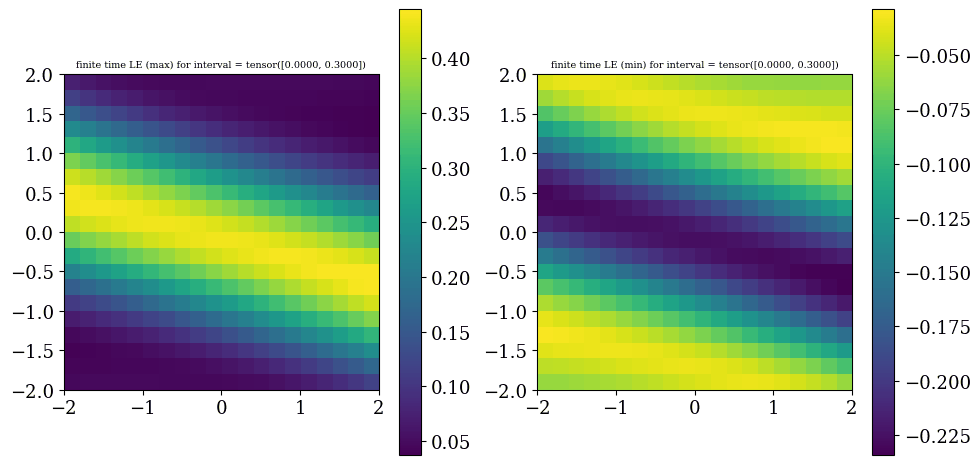

In [46]:
import imageio
import os

# Directory to save images
image_dir = 'gif_images'
if not os.path.exists(image_dir):
    os.makedirs(image_dir)

T = 10
param_layers = 10
dt = 1
x_amount = 20
# Generate and save plots
time_step = 0.3
t_values = np.arange(time_step, T-time_step, time_step)
for t in t_values:
    time_interval = torch.tensor([0, t], dtype=torch.float32)
    
    output_max, output_min = LE_grid(anode, x_amount, time_interval)
    
    # Create a figure with 2 subplots side by side
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    
    # Plot output_min on the first subplot
    im1 = axs[0].imshow(np.rot90(output_max), origin='upper', extent=(-2, 2, -2, 2), cmap='viridis')
    # im1.set_clim(vmin=vmin_max, vmax=vmax_max)
    fig.colorbar(im1, ax=axs[0], orientation='vertical')  # Show color scale
    axs[0].set_title(f'finite time LE (max) for interval = {time_interval}', fontsize=7)
    
    # Plot output_max on the second subplot
    im2 = axs[1].imshow(np.rot90(output_min), origin='upper', extent=(-2, 2, -2, 2), cmap='viridis')
    fig.colorbar(im2, ax=axs[1], orientation='vertical')  # Show color scale
    axs[1].set_title(f'finite time LE (min) for interval = {time_interval}', fontsize=7)
    # im2.set_clim(vmin_min,vmax_min)
    
    
    # Adjust layout to prevent overlap
    plt.tight_layout()
    
    filename = os.path.join(image_dir, f'plot_{t:.1f}.png')
    plt.savefig(filename, bbox_inches='tight', dpi=100, format='png', facecolor='white')
    plt.close()

# Create GIF
images = []
for t in t_values:
    filename = os.path.join(image_dir, f'plot_{t:.1f}.png')
    images.append(imageio.imread(filename))

imageio.mimsave('finite_time_LE_test.gif', images, fps=1)

# Clean up (optional)
for t in t_values:
    os.remove(os.path.join(image_dir, f'plot_{t:.1f}.png'))
os.rmdir(image_dir)

LEevo_test = Image(filename="finite_time_LE_test.gif")
display(LEevo_test)